## 图片数据建模流程范例 

1. 数据准备
- cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile
- cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。
- 在tensorflow中准备图片数据的常用方案有两种：
  1. tf.keras中的ImageDataGenerator工具构建图片数据生成器
  2. TensorFlow的原生方法：更加灵活，使用得当的话也可以获得更好的性能

In [1]:
# TensorFlow的原生方法
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models
BATCH_SIZE = 100
print(tf.test.is_gpu_available)
def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*automobile.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

2023-08-18 10:28:41.603746: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 10:28:41.843091: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 10:28:41.844924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 10:28:43.451374: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<function is_gpu_available at 0x7f6fcc408040>


In [2]:
#使用并行化预处理num_parallel_calls 和预存数据prefetch来提升性能
ds_train = tf.data.Dataset.list_files("../data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE) 

2023-08-18 10:28:48.007180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-18 10:28:48.182428: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
ds_test = tf.data.Dataset.list_files("../data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE) 

In [4]:
ds_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int8, name=None))>

In [5]:
import matplotlib.pyplot as plt 

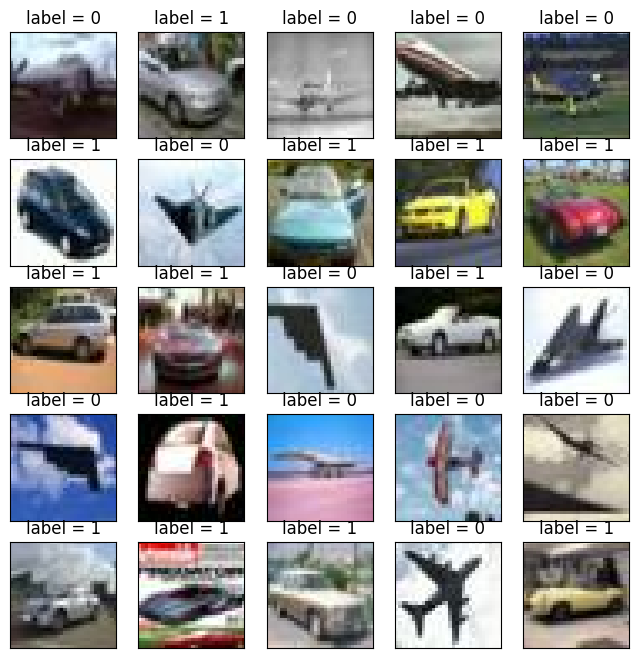

In [6]:
plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(25)):
    ax=plt.subplot(5,5,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [7]:
for x,y in ds_train.take(1):
    print(x.shape,y.shape)

(100, 32, 32, 3) (100,)


2. 模型定义
- 3种方式构建模型：
  1. 使用Sequential按层顺序构建模型；
  2. 使用函数式API构建任意结构模型；
  3. 继承Model基类构建自定义模型

In [8]:
# 此处选择使用函数式API构建模型。
tf.keras.backend.clear_session() #清空会话
inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

In [9]:
model = models.Model(inputs = inputs,outputs = outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0     

3. 训练模型
   - 通常有3种方法：
     1. 内置fit方法；
     2. 内置train_on_batch方法；
     3. 以及自定义训练循环

In [11]:
# 选择最常用也最简单的内置fit方法
import datetime
import os

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
from pathlib import Path
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = str(Path('../data/cifar2/autograph/' + stamp))

# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = os.path.join('data', 'autograph', stamp)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=["accuracy"]
    )

In [12]:
history = model.fit(ds_train,epochs= 10,validation_data=ds_test,
                    callbacks = [tensorboard_callback],workers = 4)

Epoch 1/10
100/100 [==============================] - 26s 229ms/step - loss: 0.4284 - accuracy: 0.7919 - val_loss: 0.2907 - val_accuracy: 0.8750
Epoch 2/10
100/100 [==============================] - 8s 74ms/step - loss: 0.3052 - accuracy: 0.8659 - val_loss: 0.2619 - val_accuracy: 0.8890
Epoch 3/10
100/100 [==============================] - 8s 72ms/step - loss: 0.2481 - accuracy: 0.8965 - val_loss: 0.2159 - val_accuracy: 0.9175
Epoch 4/10
100/100 [==============================] - 8s 73ms/step - loss: 0.2094 - accuracy: 0.9191 - val_loss: 0.2289 - val_accuracy: 0.9115
Epoch 5/10
100/100 [==============================] - 8s 73ms/step - loss: 0.1828 - accuracy: 0.9265 - val_loss: 0.2023 - val_accuracy: 0.9120
Epoch 6/10
100/100 [==============================] - 7s 70ms/step - loss: 0.1513 - accuracy: 0.9423 - val_loss: 0.1719 - val_accuracy: 0.9335
Epoch 7/10
100/100 [==============================] - 7s 66ms/step - loss: 0.1404 - accuracy: 0.9460 - val_loss: 0.1621 - val_accuracy: 0.93

4. 模型评估

In [14]:
# %load_ext tensorboard
!tensorboard --logdir ../data/cifar2
from tensorboard import notebook
notebook.list() 

2023-08-18 10:32:08.073760: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 10:32:08.128032: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-18 10:32:08.129119: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 10:32:09.076171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-18 10:32:10.187006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-18 10:32:10.218029: W tensorflow/core/common_r

In [15]:
#在tensorboard中查看模型
notebook.start("--logdir ../data/cifar2")

In [16]:
import pandas as pd 

In [17]:
dfhistory = pd.DataFrame(history.history)

In [18]:
dfhistory.index = range(1,len(dfhistory) + 1)

In [19]:
dfhistory.index.name = 'epoch'

In [20]:
dfhistory

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.428362,0.7919,0.290691,0.8750
2,0.305160,0.8659,0.261854,0.8890
3,0.248059,0.8965,0.215902,0.9175
4,0.209385,0.9191,0.228944,0.9115
5,0.182767,0.9265,0.202311,0.9120
6,0.151275,0.9423,0.171852,0.9335
7,0.140428,0.9460,0.162103,0.9395
8,0.116550,0.9551,0.171447,0.9345
9,0.100508,0.9630,0.167173,0.9380


In [21]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

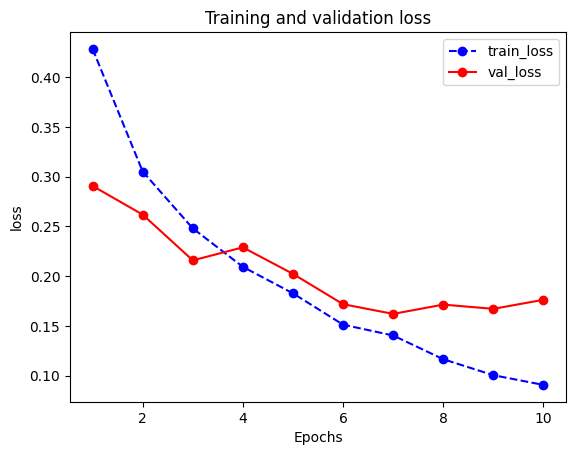

In [22]:
plot_metric(history,"loss")

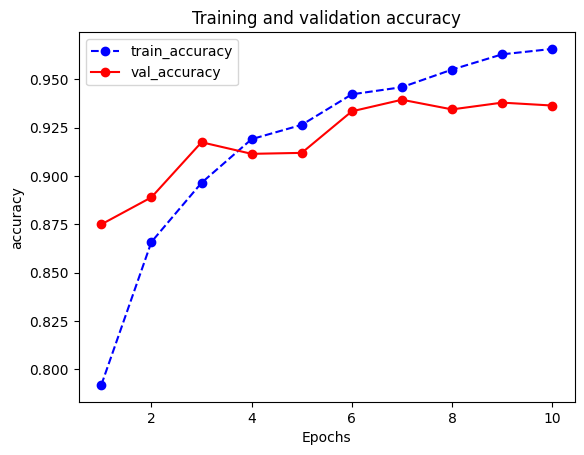

In [23]:
plot_metric(history,"accuracy")

In [24]:
#可以使用evaluate对数据进行评估
val_loss,val_accuracy = model.evaluate(ds_test,workers=4)
print(val_loss,val_accuracy)

20/20 [==============================] - 1s 52ms/step - loss: 0.1763 - accuracy: 0.9365
0.17631736397743225 0.9365000128746033


5. 使用模型预测

In [25]:
# 使用model.predict(ds_test)进行预测
model.predict(ds_test)

20/20 [==============================] - 1s 54ms/step


array([[9.0269052e-04],
       [9.9996895e-01],
       [2.5385758e-05],
       ...,
       [1.1405994e-03],
       [2.4767337e-02],
       [9.9998271e-01]], dtype=float32)

In [27]:
# 使用model.predict_on_batch(x_test)对一个批量进行预测
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

[[9.9999958e-01]
 [8.8871723e-01]
 [9.8995036e-03]
 [9.9728936e-01]
 [3.9688684e-04]
 [9.9862367e-01]
 [7.3420550e-03]
 [9.9983281e-01]
 [8.3444440e-01]
 [9.9999678e-01]
 [1.4706387e-01]
 [9.8850882e-01]
 [9.9900043e-01]
 [7.3808797e-02]
 [9.9701881e-01]
 [9.9957669e-01]
 [9.9946356e-01]
 [8.5225195e-02]
 [6.8334177e-02]
 [9.9939936e-01]]


6. 保存模型

In [28]:
# 推荐使用TensorFlow原生方式保存模型。
# 保存权重，该方式仅仅保存权重张量
model.save_weights('../data/cifar2/tf_model_weights.ckpt',save_format = "tf")

In [29]:
# 保存模型结构与模型参数到文件,该方式保存的模型具有跨平台性便于部署

model.save('../data/cifar2/tf_model_savedmodel', save_format="tf")
print('export saved model.')

INFO:tensorflow:Assets written to: ../data/cifar2/tf_model_savedmodel/assets


INFO:tensorflow:Assets written to: ../data/cifar2/tf_model_savedmodel/assets


export saved model.


In [30]:
# 加载模型
model_loaded = tf.keras.models.load_model('../data/cifar2/tf_model_savedmodel')
model_loaded.evaluate(ds_test)

20/20 [==============================] - 1s 53ms/step - loss: 0.1763 - accuracy: 0.9365


[0.17631737887859344, 0.9365000128746033]